In [1]:
import requests
from kafka import KafkaProducer
import json
import logging

# Configurer le logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def send_tan_to_kafka(topic, api_url, fields={}):
    # Kafka configuration
    kafka_config = {
        'bootstrap_servers': 'kafka1:9092',  # Update with your Kafka broker
    }

    # Initialize Kafka Producer
    producer = KafkaProducer(
        bootstrap_servers=kafka_config['bootstrap_servers'],
        value_serializer=lambda v: json.dumps(v).encode('utf-8')
    )

    try:
        # Fetch data from TAN API
        response = requests.get(api_url)

        if response.status_code == 200:
            data = response.json()

            # For each entry in the data, process and send it to Kafka
            for entry in data:
                # Process fields based on the provided mapping
                for field in fields:
                    entry[fields[field]] = entry.pop(field, None)

                # Send the data to Kafka
                producer.send(topic, value=entry)
                logger.info(f"Sent: {entry}")

            # Ensure all messages are sent
            producer.flush()
            logger.info(f"Sent {len(data)} records.")
        else:
            logger.error(f"Failed to fetch data: {response.status_code}, {response.text}")

    except requests.exceptions.RequestException as e:
        logger.error(f"Request failed: {e}")
    except Exception as e:
        logger.error(f"Kafka sending failed: {e}")
    finally:
        producer.close()

# API URL for the stop data (using f-string formatting)
latitude = "47.264"
longitude = "-1.585"
api_url = f"https://open.tan.fr/ewp/arrets.json/{latitude}/{longitude}"

# Field mappings from API response to Kafka data schema
fields = {
    "codeLieu": "stop_code",
    "libelle": "stop_name",
    "distance": "stop_distance",
}

# Example of sending the data to Kafka
send_tan_to_kafka("tan_stops", api_url, fields)

INFO:kafka.conn:<BrokerConnection client_id=kafka-python-producer-1, node_id=bootstrap-0 host=kafka1:9092 <connecting> [IPv4 ('172.18.0.7', 9092)]>: connecting to kafka1:9092 [('172.18.0.7', 9092) IPv4]
INFO:kafka.conn:Broker version identified as 2.6
INFO:kafka.conn:<BrokerConnection client_id=kafka-python-producer-1, node_id=bootstrap-0 host=kafka1:9092 <checking_api_versions_recv> [IPv4 ('172.18.0.7', 9092)]>: Connection complete.
INFO:__main__:Sent: {'ligne': [{'numLigne': '109'}, {'numLigne': '116'}, {'numLigne': '2'}, {'numLigne': '2B'}, {'numLigne': '50'}, {'numLigne': '59'}, {'numLigne': '89'}, {'numLigne': 'C2'}], 'stop_code': 'LCAR', 'stop_name': 'Le Cardo', 'stop_distance': '256 m'}
INFO:kafka.conn:<BrokerConnection client_id=kafka-python-producer-1, node_id=1 host=87488ed5e34b:9092 <connecting> [IPv4 ('172.18.0.7', 9092)]>: connecting to 87488ed5e34b:9092 [('172.18.0.7', 9092) IPv4]
INFO:__main__:Sent: {'ligne': [{'numLigne': '59'}], 'stop_code': 'AURR', 'stop_name': 'Auror

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, regexp_extract
from pyspark.sql.types import StructType, StructField, StringType, FloatType, ArrayType


# Assurez-vous que SparkSession est initialisé
spark = SparkSession.builder \
    .appName("KafkaTanData") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.4.0") \
    .getOrCreate()
# Schéma des données reçues de l'API TAN
schema = StructType([
    StructField("stop_code", StringType(), True),
    StructField("stop_name", StringType(), True),
    StructField("stop_distance", StringType(), True),
    StructField("ligne", ArrayType(StructType([
        StructField("numLigne", StringType(), True)
    ])), True)
])

# Connexion à Kafka et lecture des données
raw_stream = spark.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka1:9092") \
    .option("subscribe", "tan_stops") \
    .load()

# Traitez les données reçues depuis Kafka
parsed_stream = raw_stream.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema).alias("data")) \
    .select("data.stop_code", "data.stop_name", "data.stop_distance")

# Extraire la partie numérique de 'stop_distance' et la convertir en float
parsed_stream = parsed_stream.withColumn(
    "stop_distance",
    regexp_extract("stop_distance", r"(\d+(\.\d+)?)", 1).cast(FloatType())  # Extraction numérique et conversion
)

# Affichez les résultats pour vérifier
parsed_stream.show()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c52b46d5-3de8-435c-b77d-99fcf1f35269;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.4.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.4.0 in central
	found org.apache.kafka#kafka-clients;3.3.2 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.9.1 in central
	found org.slf4j#slf4j-api;2.0.6 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.apache.commons#commons-pool2;2.11.1 in central
:: resolution report :: resolve 1667ms :: artifacts dl 89ms
	::

+---------+---------------+-------------+
|stop_code|      stop_name|stop_distance|
+---------+---------------+-------------+
|     LCAR|       Le Cardo|        256.0|
|     AURR|         Aurore|        324.0|
|     LRHE|     Les Roches|        428.0|
|     BDLA|Bout des Landes|        432.0|
|     AURR|         Aurore|        324.0|
|     LRHE|     Les Roches|        428.0|
|     CORA|        Conraie|        430.0|
|     AURR|         Aurore|        324.0|
|     LRHE|     Les Roches|        428.0|
|     LCAR|       Le Cardo|        256.0|
|     AURR|         Aurore|        324.0|
|     LRHE|     Les Roches|        428.0|
|     BDLA|Bout des Landes|        432.0|
|     LRHE|     Les Roches|        428.0|
|     CORA|        Conraie|        430.0|
|     LCAR|       Le Cardo|        256.0|
|     CORA|        Conraie|        430.0|
|     LCAR|       Le Cardo|        256.0|
|     AURR|         Aurore|        324.0|
|     LCAR|       Le Cardo|        256.0|
+---------+---------------+-------

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
25/03/24 20:55:04 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


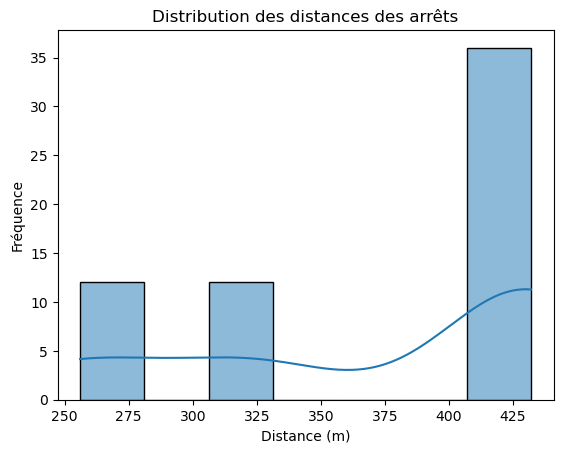

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Lecture des données du topic Kafka en mode batch
# Nous utilisons Spark pour récupérer les données du topic Kafka
batch_data = parsed_stream.collect()  # Collecte les données du DataFrame Spark en local

# Convertir les données en Pandas DataFrame pour utiliser Pandas et Seaborn
batch_df = pd.DataFrame(batch_data, columns=["stop_code", "stop_name", "stop_distance"])

# Traitement de la colonne stop_distance (convertir en float)
batch_df['stop_distance'] = batch_df['stop_distance'].apply(lambda x: float(x.replace(' m', '') if isinstance(x, str) else x))

# Visualisation des résultats avec Seaborn (par exemple, une distribution des distances des arrêts)
sns.histplot(batch_df['stop_distance'], kde=True)
plt.title("Distribution des distances des arrêts")
plt.xlabel("Distance (m)")
plt.ylabel("Fréquence")
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col, regexp_extract, count, avg, min, max, window
from pyspark.sql.types import StructType, StructField, StringType, FloatType

# Initialiser SparkSession
spark = SparkSession.builder.appName("KafkaTanData").getOrCreate()

# Schéma des données TAN
schema = StructType([
    StructField("stop_code", StringType(), True),
    StructField("stop_name", StringType(), True),
    StructField("stop_distance", StringType(), True)  # Initialement String pour extraire la partie numérique
])

# Lecture depuis Kafka
raw_stream = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka1:9092") \
    .option("subscribe", "tan_stops") \
    .load()

# Transformation des données
parsed_stream = raw_stream.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema).alias("data")) \
    .select("data.stop_code", "data.stop_name", "data.stop_distance")

# Extraction et conversion de la distance
parsed_stream = parsed_stream.withColumn(
    "stop_distance",
    regexp_extract("stop_distance", r"(\d+(\.\d+)?)", 1).cast(FloatType())  # Extraction et conversion en float
)

#  Calcul des statistiques par fenêtre de 5 minutes
stats_stream = parsed_stream \
    .groupBy(window(col("stop_code"), "5 minutes")) \
    .agg(
        count("*").alias("nombre_arrets"),  # Nombre d'arrêts reçus
        avg("stop_distance").alias("distance_moyenne"),  # Distance moyenne
        min("stop_distance").alias("distance_minimale"),  # Distance minimale
        max("stop_distance").alias("distance_maximale")  # Distance maximale
    ) \
    .select(
        col("window.start").alias("debut_fenetre"),
        col("window.end").alias("fin_fenetre"),
        col("nombre_arrets"),
        col("distance_moyenne"),
        col("distance_minimale"),
        col("distance_maximale")
    )

# Écriture dans la console
query = stats_stream.writeStream \
    .outputMode("complete") \
    .format("console") \
    .option("truncate", "false") \
    .start()

query.awaitTermination()

25/03/24 20:57:37 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-3d62a614-031f-4d9e-8664-9c3d72d1fc44. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/03/24 20:57:37 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/03/24 20:57:38 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
